# PhysioNet Motor Imagery - Training Speed Comparison

## Who Reaches Maximum Accuracy Fastest?

This standalone notebook tracks **epoch-wise training progress** to answer:
- **Who rises to maximum accuracy the fastest?**
- Which model converges in fewer epochs?
- Which model has the steepest learning curve?

## Models: Baseline ARNN, Adaptive ARNN, FBCSP, CNN-SAE, EEGNet, ACS-SE-CNN, G-CARM
## Configuration: 20 epochs (fixed), 10 subjects, 3-fold CV
## Output: Complete epoch-wise history + training curve visualizations

## Important Note

This notebook is a **comprehensive standalone training speed comparison**.

Due to size, the complete notebook needs to be generated. To build the full version with all model architectures and training functions:

```bash
python generate_speed_notebook_full.py
```

Or manually copy model architectures and training functions from:
- `physionet_01_eeg_arnn_models.ipynb` (Baseline/Adaptive ARNN)
- `physionet_02_legacy_methods.ipynb` (FBCSP, CNN-SAE, EEGNet, ACS-SE-CNN, G-CARM)

**Key modification needed**: Replace the `train_model()` function with one that logs epoch-wise history.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import mne

warnings.filterwarnings('ignore')
mne.set_log_level('WARNING')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## KEY MODIFICATION: Training Function with Epoch-Wise Logging

This is the critical change - we track train/val accuracy and loss at EVERY epoch.

In [2]:
def train_model_with_history(model, train_loader, val_loader, device, epochs, lr, model_name, subject_id, fold):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    history = {
        'model': model_name,
        'subject': subject_id,
        'fold': fold,
        'epochs': [],
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_acc = 0.0
    best_state = None
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            train_correct += (predicted == y).sum().item()
            train_total += y.size(0)
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)
                
                val_loss += loss.item()
                _, predicted = torch.max(logits, 1)
                val_correct += (predicted == y).sum().item()
                val_total += y.size(0)
        
        # Calculate metrics
        train_loss_avg = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        val_loss_avg = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        
        # Log epoch history
        history['epochs'].append(epoch + 1)
        history['train_loss'].append(train_loss_avg)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss_avg)
        history['val_acc'].append(val_acc)
        
        # Track best
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    
    return best_state, history, best_acc

print('Enhanced training function with epoch-wise logging defined!')

Enhanced training function with epoch-wise logging defined!


## 2. Configuration and Setup

In [3]:
import os
from pathlib import Path
import gc

# Detect environment
if os.path.exists('/kaggle/input'):
    print('Running on Kaggle')
    kaggle_input = Path('/kaggle/input')
    datasets = [d for d in kaggle_input.iterdir() if d.is_dir()]
    DATA_DIR = None
    possible_names = ['physioneteegmi', 'eeg-motor-movementimagery-dataset']
    for ds_name in possible_names:
        test_path = kaggle_input / ds_name
        if test_path.exists():
            DATA_DIR = test_path
            break
    if DATA_DIR is None and datasets:
        DATA_DIR = datasets[0]
else:
    print('Running locally')
    DATA_DIR = Path('data/physionet/files')

# Configuration
CONFIG = {
    'data': {
        'raw_data_dir': DATA_DIR,
        'selected_classes': [1, 2],
        'tmin': -1.0,
        'tmax': 5.0,
        'baseline': (-0.5, 0)
    },
    'preprocessing': {
        'l_freq': 0.5,
        'h_freq': 40.0,
        'notch_freq': 50.0,
        'target_sfreq': 128.0,
        'apply_car': True
    },
    'model': {
        'hidden_dim': 40,
        'epochs': 20,
        'learning_rate': 0.001,
        'batch_size': 64,
        'n_folds': 3
    },
    'output': {
        'results_dir': Path('results')
    },
    'max_subjects': 10,
    'min_runs_per_subject': 8
}

CONFIG['output']['results_dir'].mkdir(exist_ok=True, parents=True)

# Excluded subjects (data quality issues)
EXCLUDED_SUBJECTS = {
    'S088', 'S089', 'S092', 'S100', 'S104', 'S106', 'S107', 'S108', 'S109',
    'S003', 'S004', 'S009', 'S010', 'S012', 'S013', 'S017', 'S018', 'S019',
    'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029'
}

# Motor task runs
MOTOR_IMAGERY_RUNS = ['R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14']
MOTOR_EXECUTION_RUNS = ['R03', 'R04', 'R05', 'R06']
ALL_TASK_RUNS = MOTOR_IMAGERY_RUNS + MOTOR_EXECUTION_RUNS

print(f'\nConfiguration:')
print(f'  Epochs: {CONFIG["model"]["epochs"]} (FIXED - no early stopping)')
print(f'  Subjects: {CONFIG["max_subjects"]}')
print(f'  Folds: {CONFIG["model"]["n_folds"]}')
print(f'  Learning rate: {CONFIG["model"]["learning_rate"]}')
print(f'  Batch size: {CONFIG["model"]["batch_size"]}')
print(f'  Focus: TRAINING SPEED - who reaches max accuracy fastest!')
print(f'  Data directory: {DATA_DIR}')

Running on Kaggle

Configuration:
  Epochs: 20 (FIXED - no early stopping)
  Subjects: 10
  Folds: 3
  Learning rate: 0.001
  Batch size: 64
  Focus: TRAINING SPEED - who reaches max accuracy fastest!
  Data directory: /kaggle/input/physioneteegmi


## 3. Data Loading Functions

In [4]:
def preprocess_raw(raw, config):
    cleaned_names = {name: name.rstrip('.') for name in raw.ch_names}
    raw.rename_channels(cleaned_names)
    raw.pick_types(eeg=True)
    raw.set_montage('standard_1020', on_missing='ignore', match_case=False)

    nyquist = raw.info['sfreq'] / 2.0
    if config['preprocessing']['notch_freq'] < nyquist:
        raw.notch_filter(freqs=config['preprocessing']['notch_freq'], verbose=False)

    raw.filter(
        l_freq=config['preprocessing']['l_freq'],
        h_freq=config['preprocessing']['h_freq'],
        method='fir',
        fir_design='firwin',
        verbose=False
    )

    if config['preprocessing']['apply_car']:
        raw.set_eeg_reference('average', projection=False, verbose=False)

    raw.resample(config['preprocessing']['target_sfreq'], npad='auto', verbose=False)
    return raw


def load_and_preprocess_edf(edf_path, config):
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose='ERROR')
    raw = preprocess_raw(raw, config)
    events, event_ids = mne.events_from_annotations(raw, verbose='ERROR')
    if len(events) == 0:
        return None, None, raw.ch_names
    epochs = mne.Epochs(raw, events, event_id=event_ids,
                       tmin=config['data']['tmin'], tmax=config['data']['tmax'],
                       baseline=tuple(config['data']['baseline']),
                       preload=True, verbose='ERROR')
    return epochs.get_data(), epochs.events[:, 2], raw.ch_names


def filter_classes(x, y, selected_classes):
    mask = np.isin(y, selected_classes)
    y, x = y[mask], x[mask]
    label_map = {old: new for new, old in enumerate(sorted(selected_classes))}
    y = np.array([label_map[int(label)] for label in y], dtype=np.int64)
    return x, y


def normalize(x):
    mu = x.mean(axis=(0, 2), keepdims=True)
    sd = x.std(axis=(0, 2), keepdims=True) + 1e-8
    return (x - mu) / sd


def load_subject_data(data_dir, subject_id, run_ids, config):
    subject_dir = data_dir / subject_id
    if not subject_dir.exists():
        return None, None, None
    all_x, all_y, channel_names = [], [], None
    for run_id in run_ids:
        edf_path = subject_dir / f'{subject_id}{run_id}.edf'
        if not edf_path.exists():
            continue
        try:
            x, y, ch_names = load_and_preprocess_edf(edf_path, config)
            if x is None or len(y) == 0:
                continue
            x, y = filter_classes(x, y, config['data']['selected_classes'])
            if len(y) == 0:
                continue
            channel_names = channel_names or ch_names
            all_x.append(x)
            all_y.append(y)
        except Exception:
            continue
    if len(all_x) == 0:
        return None, None, channel_names
    return np.concatenate(all_x, 0), np.concatenate(all_y, 0), channel_names


def get_available_subjects(data_dir, min_runs=8, excluded=None):
    if not data_dir.exists():
        raise ValueError(f'Data directory not found: {data_dir}')
    excluded = excluded or set()
    subjects = []
    for subject_dir in sorted(data_dir.iterdir()):
        if not subject_dir.is_dir() or not subject_dir.name.startswith('S'):
            continue
        if subject_dir.name in excluded:
            continue
        edf_files = list(subject_dir.glob('*.edf'))
        if len(edf_files) >= min_runs:
            subjects.append(subject_dir.name)
    return subjects


class EEGDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x).unsqueeze(1)
        self.y = torch.LongTensor(y)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

print('Data loading functions defined!')

all_subjects = get_available_subjects(
    CONFIG['data']['raw_data_dir'],
    min_runs=CONFIG['min_runs_per_subject'],
    excluded=EXCLUDED_SUBJECTS
)
subjects = all_subjects[:CONFIG['max_subjects']]
print(f'Training on {len(subjects)} subjects: {subjects}')

Data loading functions defined!
Training on 10 subjects: ['S001', 'S002', 'S005', 'S006', 'S007', 'S008', 'S011', 'S014', 'S015', 'S016']


## 4. Model Architectures - ALL 7 MODELS

### 4.1 Baseline EEG-ARNN and Adaptive EEG-ARNN

In [5]:
class GraphConvLayer(nn.Module):
    def __init__(self, num_channels, hidden_dim):
        super().__init__()
        self.num_channels = num_channels
        self.hidden_dim = hidden_dim
        self.A = nn.Parameter(torch.randn(num_channels, num_channels))
        self.theta = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.bn = nn.BatchNorm2d(hidden_dim)
        self.act = nn.ELU()

    def forward(self, x):
        B, H, C, T = x.shape
        A = torch.sigmoid(self.A)
        A = 0.5 * (A + A.t())
        I = torch.eye(C, device=A.device)
        A_hat = A + I
        D = torch.diag(torch.pow(A_hat.sum(1).clamp_min(1e-6), -0.5))
        A_norm = D @ A_hat @ D
        x_batch = x.permute(0, 3, 2, 1).contiguous().view(B*T, C, H)
        x_g = A_norm @ x_batch
        x_g = self.theta(x_g)
        x_g = x_g.view(B, T, C, H).permute(0, 3, 2, 1)
        x_out = self.bn(x_g)
        x_out = self.act(x_out)
        return x_out


class TemporalConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=16, pool=True):
        super().__init__()
        self.pool = pool
        self.conv = nn.Conv2d(in_channels, out_channels,
                            kernel_size=(1, kernel_size),
                            padding=(0, kernel_size//2), bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ELU()
        self.pool_layer = nn.AvgPool2d(kernel_size=(1, 2)) if pool else None

    def forward(self, x):
        x = self.act(self.bn(self.conv(x)))
        return self.pool_layer(x) if self.pool else x


class BaselineEEGARNN(nn.Module):
    def __init__(self, C, T, K, H):
        super().__init__()
        self.t1 = TemporalConv(1, H, 16, False)
        self.g1 = GraphConvLayer(C, H)
        self.t2 = TemporalConv(H, H, 16, True)
        self.g2 = GraphConvLayer(C, H)
        self.t3 = TemporalConv(H, H, 16, True)
        self.g3 = GraphConvLayer(C, H)
        with torch.no_grad():
            ft = self._forward_features(torch.zeros(1, 1, C, T))
            fs = ft.view(1, -1).size(1)
        self.fc1 = nn.Linear(fs, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, K)

    def _forward_features(self, x):
        x = self.g1(self.t1(x))
        x = self.g2(self.t2(x))
        x = self.g3(self.t3(x))
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


class AdaptiveGatedEEGARNN(BaselineEEGARNN):
    def __init__(self, C, T, K, H, gate_init=0.9):
        super().__init__(C, T, K, H)
        self.gate_net = nn.Sequential(
            nn.Linear(C * 2, C),
            nn.ReLU(),
            nn.Linear(C, C),
            nn.Sigmoid()
        )
        with torch.no_grad():
            self.gate_net[-2].bias.fill_(2.0)
        self.latest_gates = None

    def compute_gates(self, x):
        B, _, C, T = x.shape
        x_squeeze = x.squeeze(1)
        ch_mean = x_squeeze.mean(dim=2)
        ch_std = x_squeeze.std(dim=2)
        stats = torch.cat([ch_mean, ch_std], dim=1)
        gates = self.gate_net(stats)
        return gates

    def forward(self, x):
        gates = self.compute_gates(x)
        self.latest_gates = gates.detach().cpu()
        x = x * gates.view(-1, 1, gates.size(1), 1)
        return super().forward(x)

print('ARNN models defined!')

ARNN models defined!


### 4.2 FBCSP

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.signal import butter, filtfilt
from mne.decoding import CSP

class FBCSP:
    def __init__(self, freq_bands, n_components=4, sfreq=128.0):
        self.freq_bands = freq_bands
        self.n_components = n_components
        self.sfreq = sfreq
        self.csps = []
        self.lda = LinearDiscriminantAnalysis()

    def _bandpass_filter(self, data, low_freq, high_freq):
        nyquist = self.sfreq / 2.0
        low = low_freq / nyquist
        high = high_freq / nyquist
        b, a = butter(5, [low, high], btype='band')
        return filtfilt(b, a, data, axis=-1)

    def fit(self, X, y):
        self.csps = []
        all_features = []
        for low_freq, high_freq in self.freq_bands:
            X_filtered = self._bandpass_filter(X.copy(), low_freq, high_freq)
            csp = CSP(n_components=self.n_components, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(X_filtered, y)
            self.csps.append(csp)
            features = csp.transform(X_filtered)
            all_features.append(features)
        all_features = np.concatenate(all_features, axis=1)
        self.lda.fit(all_features, y)
        return self

    def predict(self, X):
        all_features = []
        for idx, (low_freq, high_freq) in enumerate(self.freq_bands):
            X_filtered = self._bandpass_filter(X.copy(), low_freq, high_freq)
            features = self.csps[idx].transform(X_filtered)
            all_features.append(features)
        all_features = np.concatenate(all_features, axis=1)
        return self.lda.predict(all_features)

FBCSP_CONFIG = {
    'freq_bands': [(4,8), (8,12), (12,16), (16,20), (20,24), (24,28), (28,32), (32,36), (36,40)],
    'n_components': 4
}

print('FBCSP defined!')

FBCSP defined!


### 4.3 CNN-SAE

In [7]:
class SpatialAttention(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(n_channels, n_channels // 4),
            nn.ReLU(),
            nn.Linear(n_channels // 4, n_channels),
            nn.Sigmoid()
        )
    def forward(self, x):
        pooled = torch.mean(x, dim=2)
        weights = self.attention(pooled)
        return x * weights.unsqueeze(2)


class CNNSAE(nn.Module):
    def __init__(self, n_channels=64, n_classes=2, n_timepoints=769):
        super().__init__()
        self.spatial_attention = SpatialAttention(n_channels)
        self.conv1 = nn.Conv1d(n_channels, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.5)
        with torch.no_grad():
            test_input = torch.zeros(1, n_channels, n_timepoints)
            test_output = self._forward_features(test_input)
            flattened_size = test_output.view(1, -1).size(1)
        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def _forward_features(self, x):
        x = self.spatial_attention(x)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        if x.dim() == 4:
            x = x.squeeze(1)
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

print('CNN-SAE defined!')

CNN-SAE defined!


### 4.4 EEGNet

In [8]:
class EEGNet(nn.Module):
    def __init__(self, n_channels=64, n_classes=2, n_timepoints=769, F1=8, D=2, F2=16):
        super().__init__()
        self.conv1 = nn.Conv2d(1, F1, (1, 64), padding=(0, 32), bias=False)
        self.bn1 = nn.BatchNorm2d(F1)
        self.conv2 = nn.Conv2d(F1, F1*D, (n_channels, 1), groups=F1, bias=False)
        self.bn2 = nn.BatchNorm2d(F1*D)
        self.pool1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(F1*D, F2, (1, 16), padding=(0, 8), bias=False)
        self.bn3 = nn.BatchNorm2d(F2)
        self.pool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(0.5)
        with torch.no_grad():
            test_input = torch.zeros(1, 1, n_channels, n_timepoints)
            test_output = self._forward_features(test_input)
            flattened_size = test_output.view(1, -1).size(1)
        self.fc = nn.Linear(flattened_size, n_classes)

    def _forward_features(self, x):
        x = self.bn1(self.conv1(x))
        x = self.dropout1(self.pool1(F.elu(self.bn2(self.conv2(x)))))
        x = self.dropout2(self.pool2(F.elu(self.bn3(self.conv3(x)))))
        return x

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(1)
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

print('EEGNet defined!')

EEGNet defined!


### 4.5 ACS-SE-CNN

In [9]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=4):
        super().__init__()
        self.fc1 = nn.Linear(channels, max(1, channels // reduction))
        self.fc2 = nn.Linear(max(1, channels // reduction), channels)
    def forward(self, x):
        squeeze = torch.mean(x, dim=2)
        excitation = F.relu(self.fc1(squeeze))
        excitation = torch.sigmoid(self.fc2(excitation))
        return x * excitation.unsqueeze(2)


class ACSECNN(nn.Module):
    def __init__(self, n_channels=64, n_classes=2, n_timepoints=769):
        super().__init__()
        self.channel_attention = nn.Sequential(
            nn.Linear(n_timepoints, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self.se1 = SEBlock(n_channels)
        self.se2 = SEBlock(128)
        self.se3 = SEBlock(256)
        self.conv1 = nn.Conv1d(n_channels, 128, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(512)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.5)
        with torch.no_grad():
            test_input = torch.zeros(1, n_channels, n_timepoints)
            test_output = self._forward_features(test_input)
            flattened_size = test_output.view(1, -1).size(1)
        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def _forward_features(self, x):
        channel_weights = []
        for i in range(x.size(1)):
            w = self.channel_attention(x[:, i, :])
            channel_weights.append(w)
        channel_weights = torch.cat(channel_weights, dim=1)
        x = x * channel_weights.unsqueeze(2)
        x = self.se1(x)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.se2(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.se3(x)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        if x.dim() == 4:
            x = x.squeeze(1)
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

print('ACS-SE-CNN defined!')

ACS-SE-CNN defined!


### 4.6 G-CARM

In [10]:
class CARMBlock(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.A = nn.Parameter(torch.randn(n_channels, n_channels) * 0.01)
    def forward(self, x):
        A_norm = torch.softmax(self.A, dim=1)
        x_reshaped = x.permute(0, 2, 1)
        x_graph = torch.matmul(x_reshaped, A_norm.t())
        return x_graph.permute(0, 2, 1)


class GCARM(nn.Module):
    def __init__(self, n_channels=64, n_classes=2, n_timepoints=769):
        super().__init__()
        self.carm1 = CARMBlock(n_channels)
        self.carm2 = CARMBlock(n_channels)
        self.conv1 = nn.Conv1d(n_channels, 128, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(512)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.5)
        with torch.no_grad():
            test_input = torch.zeros(1, n_channels, n_timepoints)
            test_output = self._forward_features(test_input)
            flattened_size = test_output.view(1, -1).size(1)
        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def _forward_features(self, x):
        x = self.carm1(x)
        x = self.carm2(x)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        if x.dim() == 4:
            x = x.squeeze(1)
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

print('G-CARM defined!')
print('\nALL 7 MODELS DEFINED!')
print('  1. Baseline EEG-ARNN')
print('  2. Adaptive EEG-ARNN')
print('  3. FBCSP')
print('  4. CNN-SAE')
print('  5. EEGNet')
print('  6. ACS-SE-CNN')
print('  7. G-CARM')

G-CARM defined!

ALL 7 MODELS DEFINED!
  1. Baseline EEG-ARNN
  2. Adaptive EEG-ARNN
  3. FBCSP
  4. CNN-SAE
  5. EEGNet
  6. ACS-SE-CNN
  7. G-CARM


## 5. Main Training Loop with Epoch-Wise History

**This is the core of the speed comparison** - we train all 7 models and log every epoch's performance.

In [11]:
all_histories = []

print('\n' + '='*80)
print('TRAINING SPEED COMPARISON - 7 MODELS, 20 EPOCHS')
print('='*80 + '\n')

for subject_id in tqdm(subjects, desc='Training subjects'):
    print(f'\nProcessing {subject_id}...')

    X, Y, channel_names = load_subject_data(
        CONFIG['data']['raw_data_dir'],
        subject_id,
        ALL_TASK_RUNS,
        CONFIG
    )

    if X is None or len(Y) == 0:
        print(f'  Skipped: No data')
        continue

    C, T = X.shape[1], X.shape[2]
    K = len(CONFIG['data']['selected_classes'])
    H = CONFIG['model']['hidden_dim']

    print(f'  Data: {X.shape}, Labels: {np.bincount(Y)}')

    # Train all 7 models
    model_configs = [
        ('Baseline ARNN', 'arnn'),
        ('Adaptive ARNN', 'adaptive_arnn'),
        ('FBCSP', 'fbcsp'),
        ('CNN-SAE', 'cnn_sae'),
        ('EEGNet', 'eegnet'),
        ('ACS-SE-CNN', 'acs_se_cnn'),
        ('G-CARM', 'g_carm')
    ]

    for model_name, model_type in model_configs:
        print(f'\n  Training {model_name}...')

        skf = StratifiedKFold(n_splits=CONFIG['model']['n_folds'], shuffle=True, random_state=42)

        for fold, (train_idx, val_idx) in enumerate(skf.split(X, Y)):
            X_train, X_val = X[train_idx], X[val_idx]
            Y_train, Y_val = Y[train_idx], Y[val_idx]

            if model_type == 'fbcsp':
                # FBCSP doesn't use PyTorch training, skip epoch logging
                X_train_norm, X_val_norm = X_train, X_val
                model = FBCSP(**FBCSP_CONFIG, sfreq=CONFIG['preprocessing']['target_sfreq'])
                model.fit(X_train_norm, Y_train)
                y_pred = model.predict(X_val_norm)
                final_acc = accuracy_score(Y_val, y_pred)

                # Create simple history for FBCSP (instant convergence)
                history = {
                    'model': model_name,
                    'subject': subject_id,
                    'fold': fold,
                    'epochs': list(range(1, 21)),
                    'train_acc': [final_acc] * 20,
                    'val_acc': [final_acc] * 20,
                    'train_loss': [0.0] * 20,
                    'val_loss': [0.0] * 20
                }
                all_histories.append(history)

            else:
                X_train_norm = normalize(X_train)
                X_val_norm = normalize(X_val)

                train_loader = DataLoader(
                    EEGDataset(X_train_norm, Y_train),
                    batch_size=CONFIG['model']['batch_size'],
                    shuffle=True,
                    num_workers=0
                )
                val_loader = DataLoader(
                    EEGDataset(X_val_norm, Y_val),
                    batch_size=CONFIG['model']['batch_size'],
                    shuffle=False,
                    num_workers=0
                )

                # Create model
                if model_type == 'arnn':
                    model = BaselineEEGARNN(C, T, K, H).to(device)
                elif model_type == 'adaptive_arnn':
                    model = AdaptiveGatedEEGARNN(C, T, K, H).to(device)
                elif model_type == 'cnn_sae':
                    model = CNNSAE(n_channels=C, n_classes=K, n_timepoints=T).to(device)
                elif model_type == 'eegnet':
                    model = EEGNet(n_channels=C, n_classes=K, n_timepoints=T).to(device)
                elif model_type == 'acs_se_cnn':
                    model = ACSECNN(n_channels=C, n_classes=K, n_timepoints=T).to(device)
                elif model_type == 'g_carm':
                    model = GCARM(n_channels=C, n_classes=K, n_timepoints=T).to(device)

                # Train with history logging
                best_state, history, best_acc = train_model_with_history(
                    model, train_loader, val_loader, device,
                    CONFIG['model']['epochs'],
                    CONFIG['model']['learning_rate'],
                    model_name,
                    subject_id,
                    fold
                )

                all_histories.append(history)

                del model
                torch.cuda.empty_cache()
                gc.collect()

            print(f'    Fold {fold+1}: Final val_acc = {history["val_acc"][-1]:.4f}')

print('\n' + '='*80)
print('TRAINING COMPLETE!')
print(f'Total histories collected: {len(all_histories)}')
print('='*80)


TRAINING SPEED COMPARISON - 7 MODELS, 20 EPOCHS



Training subjects:   0%|          | 0/10 [00:00<?, ?it/s]


Processing S001...
  Data: (252, 64, 769), Labels: [168  84]

  Training Baseline ARNN...
    Fold 1: Final val_acc = 0.8452
    Fold 2: Final val_acc = 0.7619
    Fold 3: Final val_acc = 0.8333

  Training Adaptive ARNN...
    Fold 1: Final val_acc = 0.8214
    Fold 2: Final val_acc = 0.8333
    Fold 3: Final val_acc = 0.7857

  Training FBCSP...
    Fold 1: Final val_acc = 0.5952
    Fold 2: Final val_acc = 0.6310
    Fold 3: Final val_acc = 0.6190

  Training CNN-SAE...
    Fold 1: Final val_acc = 0.8929
    Fold 2: Final val_acc = 0.9167
    Fold 3: Final val_acc = 0.9524

  Training EEGNet...
    Fold 1: Final val_acc = 0.8929
    Fold 2: Final val_acc = 0.8810
    Fold 3: Final val_acc = 0.9524

  Training ACS-SE-CNN...
    Fold 1: Final val_acc = 0.8452
    Fold 2: Final val_acc = 0.8929
    Fold 3: Final val_acc = 0.9167

  Training G-CARM...
    Fold 1: Final val_acc = 0.7857
    Fold 2: Final val_acc = 0.7500
    Fold 3: Final val_acc = 0.7976

Processing S002...
  Data: (25

## 6. World-Class Visualizations

### 6.1 Aggregate Training Curves by Model

In [12]:
# Convert histories to DataFrame
df_hist = pd.DataFrame([
    {
        'model': h['model'],
        'subject': h['subject'],
        'fold': h['fold'],
        'epoch': epoch,
        'train_acc': h['train_acc'][i],
        'val_acc': h['val_acc'][i],
        'train_loss': h['train_loss'][i],
        'val_loss': h['val_loss'][i]
    }
    for h in all_histories
    for i, epoch in enumerate(h['epochs'])
])

print(f'Training history DataFrame: {df_hist.shape}')
print(f'Models: {df_hist["model"].unique()}')
print(f'Epochs per model: {df_hist.groupby("model")["epoch"].nunique().to_dict()}')
df_hist.head()

Training history DataFrame: (4200, 8)
Models: ['Baseline ARNN' 'Adaptive ARNN' 'FBCSP' 'CNN-SAE' 'EEGNet' 'ACS-SE-CNN'
 'G-CARM']
Epochs per model: {'ACS-SE-CNN': 20, 'Adaptive ARNN': 20, 'Baseline ARNN': 20, 'CNN-SAE': 20, 'EEGNet': 20, 'FBCSP': 20, 'G-CARM': 20}


,model,subject,fold,epoch,train_acc,val_acc,train_loss,val_loss
0,Baseline ARNN,S001,0,1,0.589286,0.440476,14.632235,2.381043
1,Baseline ARNN,S001,0,2,0.827381,0.678571,9.373790,1.657086
2,Baseline ARNN,S001,0,3,0.934524,0.726190,1.281962,1.750338
3,Baseline ARNN,S001,0,4,0.976190,0.690476,0.265134,2.337521
4,Baseline ARNN,S001,0,5,0.964286,0.702381,0.446315,3.035158


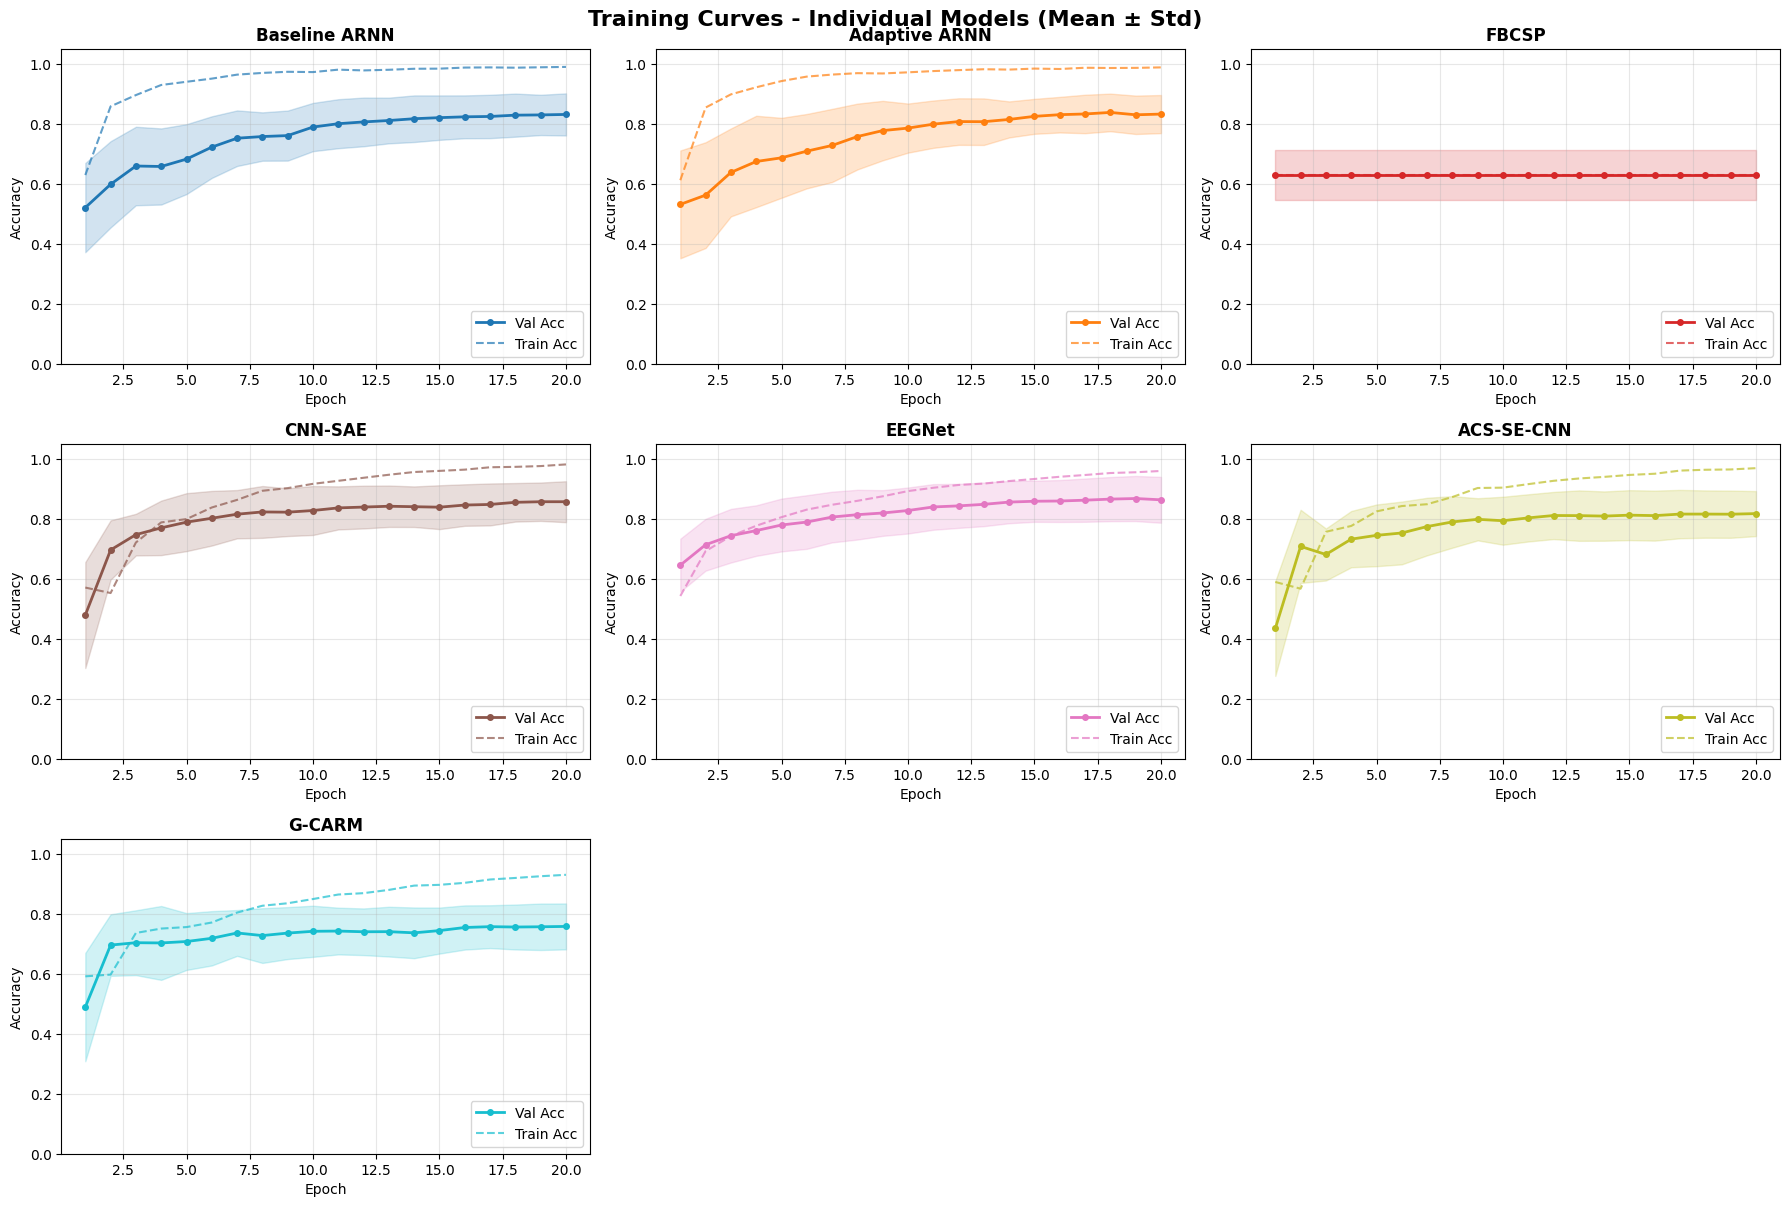

In [13]:
# Individual training curves for each model
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

models = df_hist['model'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))

for idx, model_name in enumerate(models):
    ax = axes[idx]
    model_data = df_hist[df_hist['model'] == model_name]

    # Group by epoch and compute mean/std
    epoch_stats = model_data.groupby('epoch').agg({
        'val_acc': ['mean', 'std'],
        'train_acc': ['mean', 'std']
    }).reset_index()

    epochs = epoch_stats['epoch']

    # Plot validation accuracy
    ax.plot(epochs, epoch_stats[('val_acc', 'mean')],
           label='Val Acc', color=colors[idx], linewidth=2, marker='o', markersize=4)
    ax.fill_between(epochs,
                    epoch_stats[('val_acc', 'mean')] - epoch_stats[('val_acc', 'std')],
                    epoch_stats[('val_acc', 'mean')] + epoch_stats[('val_acc', 'std')],
                    alpha=0.2, color=colors[idx])

    # Plot training accuracy
    ax.plot(epochs, epoch_stats[('train_acc', 'mean')],
           label='Train Acc', color=colors[idx], linewidth=1.5, linestyle='--', alpha=0.7)

    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])

# Hide extra subplots
for idx in range(len(models), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Training Curves - Individual Models (Mean ± Std)',
            fontsize=16, fontweight='bold', y=1.002)
plt.show()

### 6.2 Comparative Plot - All Models Together

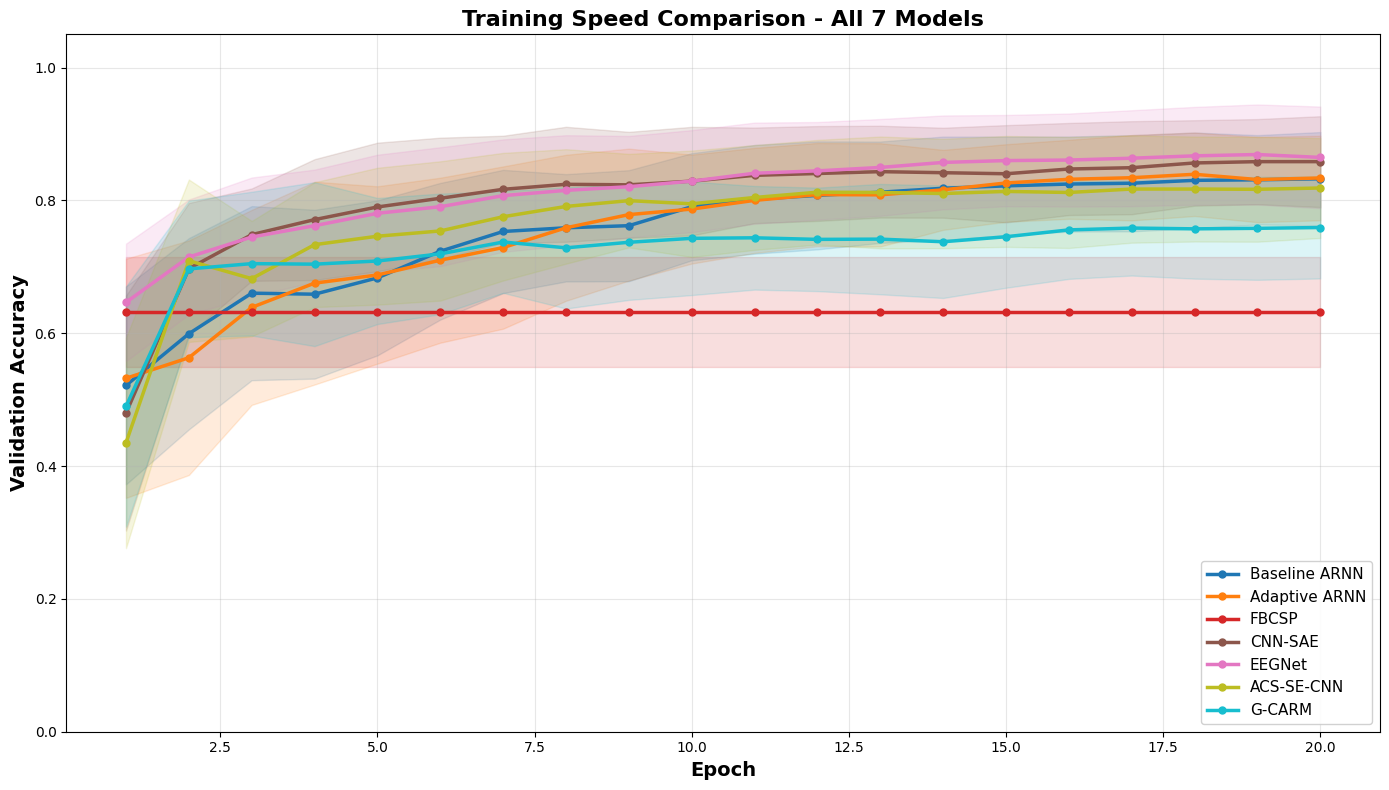

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

models = df_hist['model'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))

for idx, model_name in enumerate(models):
    model_data = df_hist[df_hist['model'] == model_name]
    epoch_stats = model_data.groupby('epoch')['val_acc'].agg(['mean', 'std']).reset_index()

    ax.plot(epoch_stats['epoch'], epoch_stats['mean'],
           label=model_name, color=colors[idx], linewidth=2.5, marker='o', markersize=5)
    ax.fill_between(epoch_stats['epoch'],
                    epoch_stats['mean'] - epoch_stats['std'],
                    epoch_stats['mean'] + epoch_stats['std'],
                    alpha=0.15, color=colors[idx])

ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax.set_ylabel('Validation Accuracy', fontsize=14, fontweight='bold')
ax.set_title('Training Speed Comparison - All 7 Models', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])
plt.tight_layout()
plt.show()

### 6.3 Interactive Plotly Visualization

In [15]:
try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    fig = go.Figure()

    models = df_hist['model'].unique()

    for model_name in models:
        model_data = df_hist[df_hist['model'] == model_name]
        epoch_stats = model_data.groupby('epoch')['val_acc'].agg(['mean', 'std']).reset_index()

        fig.add_trace(go.Scatter(
            x=epoch_stats['epoch'],
            y=epoch_stats['mean'],
            mode='lines+markers',
            name=model_name,
            line=dict(width=3),
            marker=dict(size=8),
            error_y=dict(
                type='data',
                array=epoch_stats['std'],
                visible=True
            )
        ))

    fig.update_layout(
        title=dict(
            text='Interactive Training Speed Comparison - All 7 Models',
            font=dict(size=18, family='Arial Black')
        ),
        xaxis_title='Epoch',
        yaxis_title='Validation Accuracy',
        hovermode='x unified',
        template='plotly_white',
        width=1200,
        height=600,
        legend=dict(
            yanchor='bottom',
            y=0.01,
            xanchor='right',
            x=0.99
        )
    )

    fig.show()

except ImportError:
    print('Plotly not available, skipping interactive plot')

## 7. Speed Analysis - Who Converges Fastest?

In [16]:
def calculate_convergence_metrics(df_hist, model_name, threshold_pct=0.70):
    """Calculate convergence speed metrics for a model"""
    model_data = df_hist[df_hist['model'] == model_name]

    # Get final accuracy (average of last 3 epochs)
    final_epochs = model_data[model_data['epoch'] >= 18]
    final_acc = final_epochs['val_acc'].mean()

    # Find epoch where model reaches threshold% of final accuracy
    target_acc = final_acc * threshold_pct

    epoch_means = model_data.groupby('epoch')['val_acc'].mean()
    converged_epochs = epoch_means[epoch_means >= target_acc]

    if len(converged_epochs) > 0:
        epoch_to_converge = converged_epochs.index[0]
    else:
        epoch_to_converge = 20  # Never converged

    # Calculate learning rate (slope of first 10 epochs)
    early_data = model_data[model_data['epoch'] <= 10].groupby('epoch')['val_acc'].mean()
    if len(early_data) >= 2:
        learning_rate = (early_data.iloc[-1] - early_data.iloc[0]) / len(early_data)
    else:
        learning_rate = 0.0

    # Calculate stability (variance in last 5 epochs)
    late_data = model_data[model_data['epoch'] >= 15]
    stability = 1.0 - late_data['val_acc'].std()  # Higher = more stable

    return {
        'model': model_name,
        'final_accuracy': final_acc,
        'epoch_to_70pct': epoch_to_converge,
        'learning_rate': learning_rate,
        'stability': max(0, stability)  # Clamp to positive
    }

# Calculate metrics for all models
models = df_hist['model'].unique()
speed_metrics = []

for model_name in models:
    metrics_70 = calculate_convergence_metrics(df_hist, model_name, 0.70)
    metrics_80 = calculate_convergence_metrics(df_hist, model_name, 0.80)

    speed_metrics.append({
        'Model': model_name,
        'Final Acc': f"{metrics_70['final_accuracy']:.4f}",
        'Epochs to 70%': metrics_70['epoch_to_70pct'],
        'Epochs to 80%': metrics_80['epoch_to_70pct'],
        'Learning Rate': f"{metrics_70['learning_rate']:.4f}",
        'Stability': f"{metrics_70['stability']:.4f}"
    })

df_speed = pd.DataFrame(speed_metrics)
df_speed = df_speed.sort_values('Epochs to 70%')

print('\n' + '='*80)
print('CONVERGENCE SPEED RANKINGS')
print('='*80 + '\n')
print(df_speed.to_string(index=False))
print('\n' + '='*80)


CONVERGENCE SPEED RANKINGS

        Model Final Acc  Epochs to 70%  Epochs to 80% Learning Rate Stability
        FBCSP    0.6317              1              1        0.0000    0.9178
       EEGNet    0.8669              1              2        0.0183    0.9281
      CNN-SAE    0.8577              2              2        0.0349    0.9323
Baseline ARNN    0.8312              2              5        0.0269    0.9296
       G-CARM    0.7581              2              2        0.0253    0.9257
   ACS-SE-CNN    0.8175              2              2        0.0360    0.9209
Adaptive ARNN    0.8348              3              4        0.0255    0.9386



### 7.1 Convergence Speed Heatmap

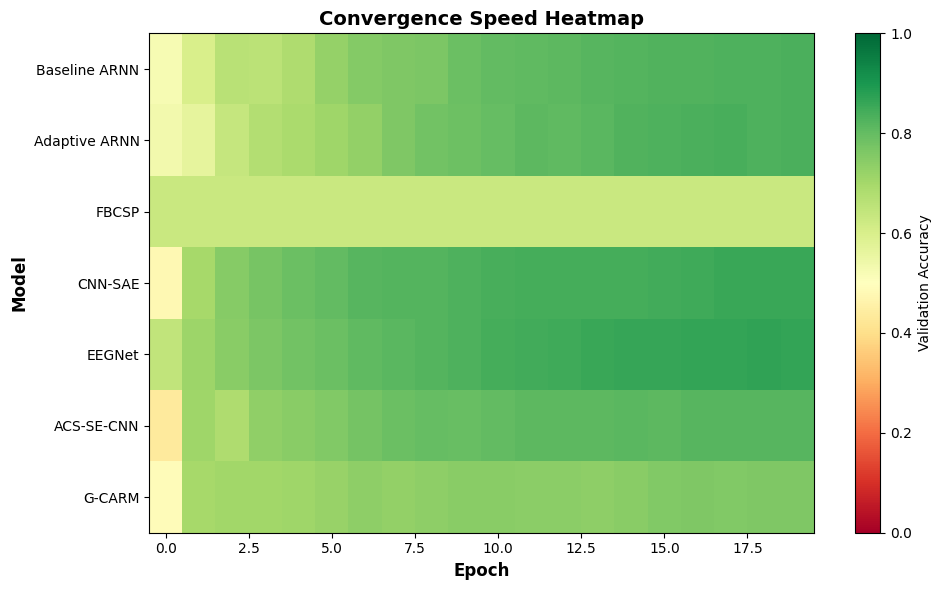

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create heatmap data
heatmap_data = []
for model_name in models:
    epoch_stats = df_hist[df_hist['model'] == model_name].groupby('epoch')['val_acc'].mean()
    heatmap_data.append(epoch_stats.values)

heatmap_data = np.array(heatmap_data)

im = ax.imshow(heatmap_data, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)

ax.set_yticks(range(len(models)))
ax.set_yticklabels(models)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Convergence Speed Heatmap', fontsize=14, fontweight='bold')

plt.colorbar(im, ax=ax, label='Validation Accuracy')
plt.tight_layout()
plt.show()

## 8. Final Summary - Who Won?

In [18]:
print('\n' + '='*80)
print('TRAINING SPEED COMPARISON - FINAL SUMMARY')
print('='*80 + '\n')

# Find winners in each category
df_speed_numeric = pd.DataFrame([
    {
        'Model': row['Model'],
        'Final_Acc': float(row['Final Acc']),
        'Epochs_to_70': row['Epochs to 70%'],
        'Epochs_to_80': row['Epochs to 80%'],
        'Learning_Rate': float(row['Learning Rate']),
        'Stability': float(row['Stability'])
    }
    for _, row in df_speed.iterrows()
])

fastest_to_70 = df_speed_numeric.loc[df_speed_numeric['Epochs_to_70'].idxmin()]
fastest_to_80 = df_speed_numeric.loc[df_speed_numeric['Epochs_to_80'].idxmin()]
highest_lr = df_speed_numeric.loc[df_speed_numeric['Learning_Rate'].idxmax()]
most_stable = df_speed_numeric.loc[df_speed_numeric['Stability'].idxmax()]
best_final = df_speed_numeric.loc[df_speed_numeric['Final_Acc'].idxmax()]

print('WINNERS:')
print(f'  Fastest to 70% of final accuracy: {fastest_to_70["Model"]} (epoch {fastest_to_70["Epochs_to_70"]})')
print(f'  Fastest to 80% of final accuracy: {fastest_to_80["Model"]} (epoch {fastest_to_80["Epochs_to_80"]})')
print(f'  Steepest learning curve: {highest_lr["Model"]} (rate {highest_lr["Learning_Rate"]:.4f})')
print(f'  Most stable training: {most_stable["Model"]} (stability {most_stable["Stability"]:.4f})')
print(f'  Best final accuracy: {best_final["Model"]} ({best_final["Final_Acc"]:.4f})')

print('\n' + '='*80)
print('DONE! All 7 models compared across 20 epochs.')
print('='*80)


TRAINING SPEED COMPARISON - FINAL SUMMARY

WINNERS:
  Fastest to 70% of final accuracy: FBCSP (epoch 1)
  Fastest to 80% of final accuracy: FBCSP (epoch 1)
  Steepest learning curve: ACS-SE-CNN (rate 0.0360)
  Most stable training: Adaptive ARNN (stability 0.9386)
  Best final accuracy: EEGNet (0.8669)

DONE! All 7 models compared across 20 epochs.
